# ESD_thermotrace
##### A jupyter notebook that helps interpreting detrital tracer thermochronometry datasets and quantifying the statistical confidence of such analysis. Developed by A. Madella in the [Earth Surface Dynamics group of the University of Tuebingen](https://uni-tuebingen.de/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/geowissenschaften/arbeitsgruppen/mineralogie-geodynamik/forschungsbereich/geologie/earth-system-dynamics-research-group/).
##### The code was last updated in February 2021.


### Indicate the path to the input text file

In [1]:
# Indicate the path to the input text file here 
input_file = 'input_highsierra/input_file_wslope.txt'

### Import libraries and input parameters

In [2]:
# import all libraries and functions
from ESD_thermotrace_functions import *

# The following line activates the display of all plots underneath the related cell
%matplotlib inline
# # Alternatively, an interactive window for every figure can be opened, uncommenting the next line
# %matplotlib notebook 

# This sets all figures to have a white background and large fontsize
sns.set(style='white', context='talk')

# read and parse input file
input_txt = read_input_file(input_file)
# get all parameters from parsed textfile and print them below for a check
ipf, opf = input_txt[0][-1], input_txt[1][-1]
dem_filename = input_txt[2][-1]
e_map_filenames = input_txt[3][-1]
f_map_filename = input_txt[4][-1]
ws_filename = input_txt[5][-1]
bedrock_ages_filename = input_txt[6][-1]
detrital_ages_filenames = input_txt[7][-1]
res = input_txt[8][-1]
example_scenarios = input_txt[9][-1]
interp_method = input_txt[10][-1]
ext_rad = input_txt[11][-1]
age_map_filename = input_txt[12][-1]
age_map_u_filename = input_txt[13][-1]

print('THESE ARE YOUR INPUT PARAMETERS:\n')
for line in input_txt:
    print('{}: {}\n'.format(line[1],line[2]))

THESE ARE YOUR INPUT PARAMETERS:

input_folder: input_highsierra

output_folder: output_highsierra

dem_filename: dem_highsierra.asc

erosion_map_filenames: ['slope_highsierra.asc']

fertility_map_filename: None

watershed_outline_filename: inyo_ws.shp

bedrock_ages_filename: bd_highsierra.xlsx

detrital_ages_filenames: ['dd_inyo_fine.xlsx']

resolution: 90

example_scenarios: False

interpolation_method: zln

extrapolation_radius: None

age_map_filename: None

age_map_uncertainty_filename: None



### Import data and display them

In [3]:
# Open DEM and read the metadata, then print them below
dem = import_dem(dem_filename, ipf)
# make a dictionary of all erosion maps and the fertility map, if present
e_maps = import_e_maps(e_map_filenames, f_map_filename, ipf)
# import the interpolated age map and uncertainty, if specified
age_map, age_map_u = import_age_map(age_map_filename, age_map_u_filename, ipf, interp_method)


METADATA OF dem_highsierra

xllcorner = -118.305972222165
yllcorner = 36.53652777782
ncols = 489
nrows = 262
cellsize [km] = 0.000277777778
cellsize [m] = ~30
min value = 1676.0
max value = 4401.0
NODATA_value = nan

METADATA OF slope_highsierra

xllcorner = -118.305972222165
yllcorner = 36.53652777782
ncols = 489
nrows = 262
cellsize [km] = 0.000277777778
cellsize [m] = ~30
min value = 0.0
max value = 74.6423
NODATA_value = nan


/Users/andrea/Documents/docs/src/Python/ESD_thermotrace/ESD_thermotrace_public/ESD_thermotrace_functions.py:278: UserWarning: The column "zero_age_depth" contains Nans
 all zero age depths will be set to z-5000m
  warnings.warn('The column "zero_age_depth" contains Nans\n all zero age depths will be set to z-5000m')


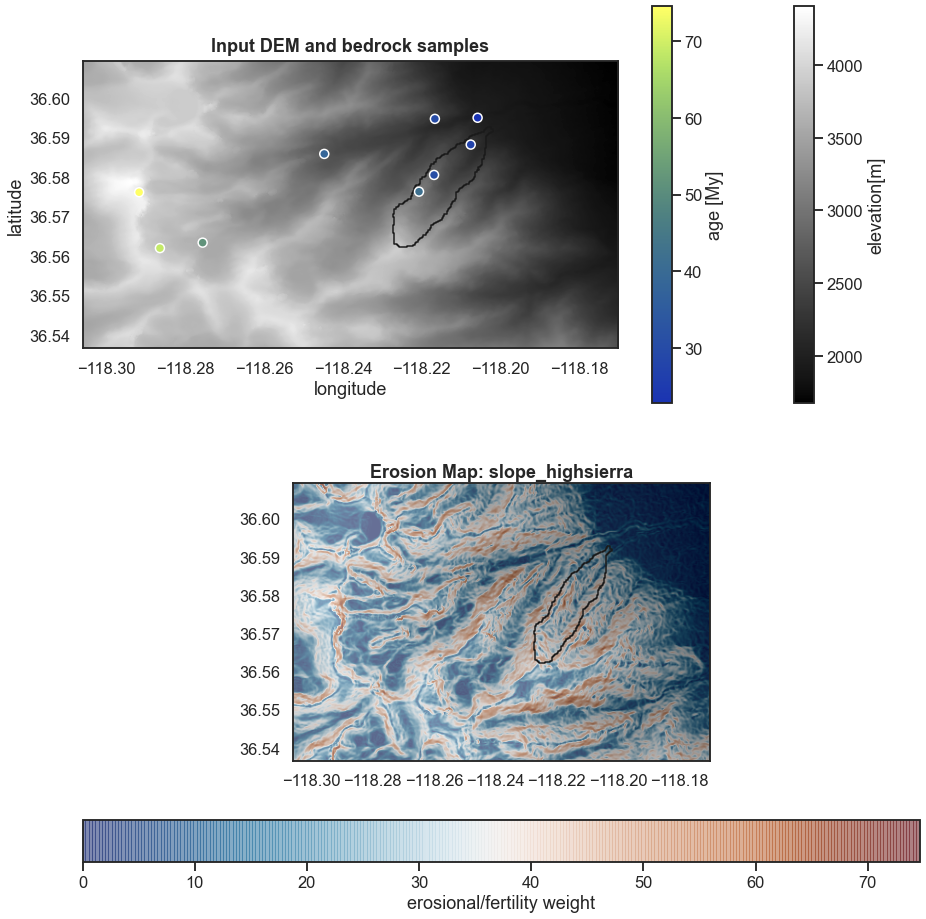

In [4]:
# import bedrock age dataset into a pandas.DataFrame
if interp_method != 'imp':
    bd, z, a, u, lat, lon, x_utm, y_utm, xx_utm, yy_utm, zz, aa = import_bedrock_data(ipf+'/'+bedrock_ages_filename)
else: # the bedrock data is not needed if the age map is imported
    bd = None
# import watershed outline as geopandas.DataFrame 
ws_outline = gpd.read_file(ipf+'/'+ws_filename) 

# make output directory and subfolder, if not existing yet
if not path.exists(opf):
    mkdir(opf)
if not path.exists(opf+'/temp'):
    mkdir(opf+'/temp')

# assign all colormaps, taken from ScientifiColorMaps6
dem_cmap, age_cmap, ero_cmap, err_cmap= scm6.grayC.reversed(), scm6.imola, scm6.vik, scm6.lajolla.reversed()

# plot dem and point data to check that everything worked fine    
plot_input_data(dem, e_maps, ws_outline, interp_method, bd, dem_cmap, age_cmap, ero_cmap,
                age_map, age_map_u, opf+'/input_data.pdf')

### Resample all input rasters and interpolate ages to the resampled topographic surface

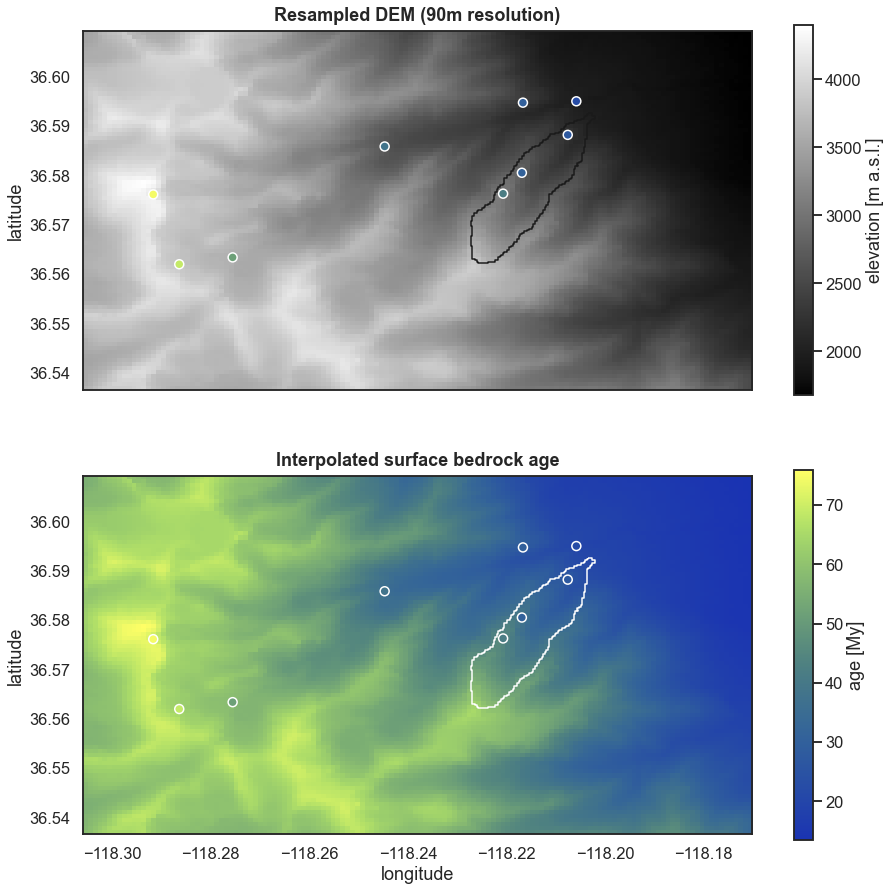

In [5]:
dem.resample(res) # resample DEM
if len(e_maps)>0:
    for k,i in e_maps.items():
        i.resample(res, xyll=dem.xyll, xyur=dem.xyur, extent84=dem.extent84)

# Interpolate age data onto the topographic surface according to chosen method.
if interp_method =='imp':
    age_map.resample(res, xyll=dem.xyll, xyur=dem.xyur, extent84=dem.extent84) # resample imported age map
    age_interp_map = age_map.zi_res

elif interp_method == 'rbf': # radial basis function
    rbfi = intr.Rbf(xx_utm, yy_utm, zz, aa, function='linear')
    age_interp_map = rbfi(dem.xi_res, dem.yi_res, dem.zi_res)

elif interp_method == 'zln': # simple 1D linear regression from age-elevation data
    reg0 = LinearRegression().fit(z.reshape(-1,1),a.reshape(-1,1))
    intercept0, coef0, R2 = reg0.intercept_, reg0.coef_, np.around(reg0.score(z.reshape(-1,1),a.reshape(-1,1)), 2)
    if R2 < 0.7:
        warnings.warn('\nLarge scatter of age-elevation data (R^2 = '+str(R2)+') \nYou might want to use a different interpolation method')
    age_interp_map = intercept0+coef0*dem.zi_res

else: # grid-data interpolation (3D linear)
    age_int = intr.griddata(np.concatenate(([xx_utm],[yy_utm],[zz])).transpose(), # known X
                            aa, # known Y
                            np.concatenate(([dem.xi_res_1d],[dem.yi_res_1d],[dem.zi_res_1d])).transpose()) # new X
    if interp_method == 'ext': # call extrapolation function if needed
        age_int = extrapolation(age_int,dem.xi_res_1d,dem.yi_res_1d,dem.zi_res_1d,a,x_utm,y_utm,z,ext_rad) 
    age_interp_map = age_int.reshape(dem.zi_res.shape) # reshape 1D output to correct 2D format   
    
# Plot resampled DEM and interpolated age map
plot_resDEM_and_age_map(dem, res, age_interp_map, bd, ws_outline, interp_method, dem_cmap, age_cmap,
                        opf+'/DEMres'+str(res)+'_ageinterp.pdf')

### Make error map

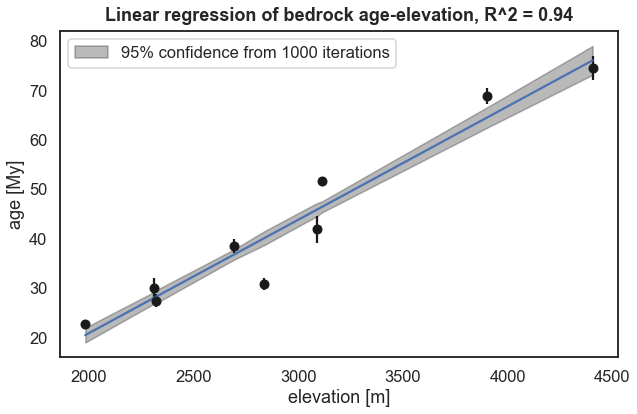

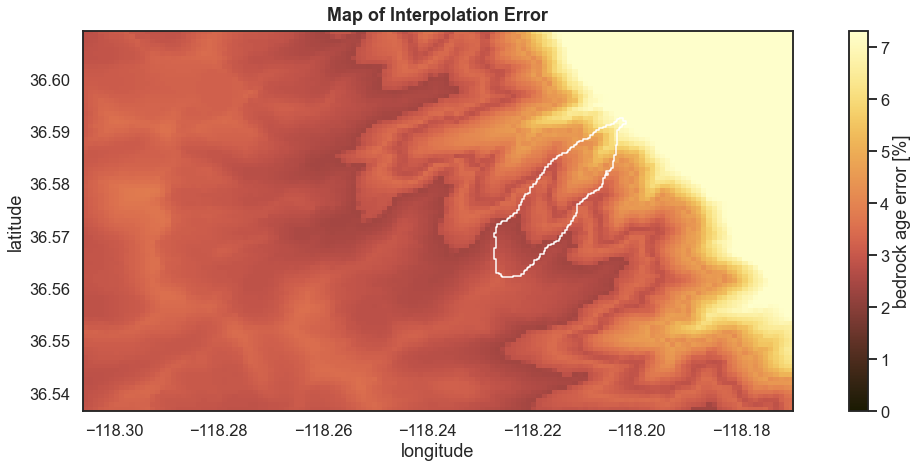

In [6]:
# make error map by bootstrapping the known data points
if interp_method != 'imp' and interp_method != 'zln':
    error_interp, age_interp_error_map = make_errormap(dem, res, z, a, u, aa, xx_utm, yy_utm, zz, x_utm, y_utm,
                                                      interp_method, ext_rad)

elif interp_method == 'zln':
    error_interp, age_interp_error_map = make_errormap_zln(dem, z, a, u)
    plot_linreg(R2, reg0, z, a, u, error_interp, opf+'/linear_regression.pdf') # Plot linear regr, if it applies

elif interp_method == 'imp':
    age_map_u.resample(res, xyll=dem.xyll, xyur=dem.xyur, extent84=dem.extent84) # resample imported age error map
    age_interp_error_map = age_map_u.zi_res
    
# plot error map
plot_error_map(age_interp_error_map, error_interp, bd, ws_outline, interp_method, err_cmap, dem.extent84,
               opf+'/age_interp_error_map.pdf')

## Clip to watershed 

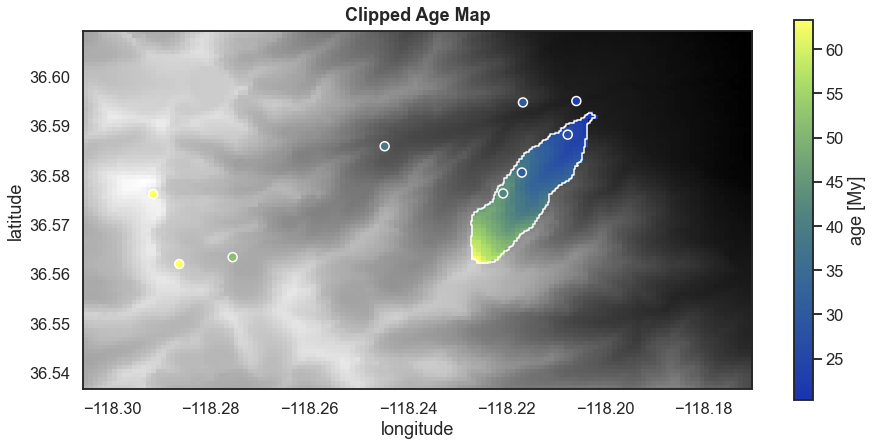

In [7]:
# clip all rasters to the imported watershed
xi_res_clp = clip_to_ws(dem.xi_res, ws_filename, dem.extent84, ipf, opf)
yi_res_clp = clip_to_ws(dem.yi_res, ws_filename, dem.extent84, ipf, opf)
zi_res_clp = clip_to_ws(dem.zi_res, ws_filename, dem.extent84, ipf, opf)

e_maps_res_clp = dict()
if len(e_maps)>0:
    for key,item in e_maps.items():
        e_maps_res_clp[key] = clip_to_ws(item.zi_res, ws_filename, dem.extent84, ipf, opf)
        
age_interp_map_clp = clip_to_ws(age_interp_map, ws_filename, dem.extent84, ipf, opf)
age_interp_error_map_clp = clip_to_ws(age_interp_error_map, ws_filename, dem.extent84, ipf, opf)

# plot the clipped age map
plot_clipped_age_map(dem, age_interp_map_clp, ws_outline, bd, interp_method, dem_cmap, age_cmap,
                     opf+'/clipped_age_map.pdf')

## Make a table of x, y, z, age, error, erosion

In [8]:
# Compile table with default data and example scenarios
dflt_grids = [xi_res_clp, yi_res_clp, zi_res_clp, age_interp_map_clp, age_interp_error_map_clp] # grids to extract
dflt_labels = ['x', 'y', 'z', 'age', 'age_u%'] # labels for each of the grids above
ws_data = make_watershed_table(dflt_grids, dflt_labels, e_maps, e_maps_res_clp, example_scenarios)

# Here one can play around with other erosional functions
# first define the function, then create the related columns, like this example:
def E_stepwise(z, z_steps, weights):
    '''
    example erosional function of z, where prescribed erosional weights
    are assigned for certain elevation ranges
    z: elevation at which erosional weight is assigned
    z_steps: list of elevation thresholds, ascending
    weights: list of corresponding erosional weights
    '''
    if z>z_steps[-1]:
        warnings.warn('also elevations above {} have been assigned {} \
        as erosional weight'.format(z_steps[-1], weights[-1]))
        return weights[-1]
    else:
        z_steps_a = np.array(z_steps)
        return weights[z_steps.index(z_steps_a[z<z_steps_a][0])]

# example scenarios for the submitted manuscript: 2-fold increas and decrease in erosion at 3000 m elevation
e_steps = [3000,4000]
e_weights = [2,1]
ws_data['E<3000'] = ws_data.z.apply(lambda z: E_stepwise(z,e_steps,e_weights))
ws_data['E<3000'] = ws_data['E<3000']/ws_data['E<3000'].min()

# e_steps = [3000,4000]
# e_weights = [1,2]
# ws_data['E>3000'] = ws_data.z.apply(lambda z: E_stepwise(z,e_steps,e_weights))
# ws_data['E>3000'] = ws_data['E>3000']/ws_data['E>3000'].min()

# slope-dependent erosion
ws_data.slope_highsierra = np.exp(ws_data.slope_highsierra/ws_data.slope_highsierra.min())
ws_data.slope_highsierra = ws_data.slope_highsierra/ws_data.slope_highsierra.min()

# save table to excel and show it
ws_data.to_excel(opf+'/xyz_age_eros.xlsx', index=False)
print('TABLE OF CATCHMENT DATA:')
ws_data

TABLE OF CATCHMENT DATA:


,x,y,z,age,age_u%,slope_highsierra,Euni,E<3000
0,392455.296213,4.050373e+06,1975.0,20.302102,7.317062,1.763197,1.0,2.0
3,392545.296213,4.050283e+06,1987.0,20.577670,7.298344,1.000000,1.0,2.0
2,392455.296213,4.050283e+06,1997.0,20.807310,7.204755,3.620137,1.0,2.0
1,392365.296213,4.050283e+06,2012.0,21.151770,7.064372,6.886428,1.0,2.0
6,392365.296213,4.050193e+06,2044.0,21.886618,6.764889,6.169419,1.0,2.0
...,...,...,...,...,...,...,...,...
373,390475.296213,4.047043e+06,3744.0,60.925421,3.051054,129.636350,1.0,1.0
359,390295.296213,4.047223e+06,3748.0,61.017277,3.055131,44.950271,1.0,1.0
367,390385.296213,4.047133e+06,3797.0,62.142513,3.105072,1723.430894,1.0,1.0
366,390295.296213,4.047133e+06,3847.0,63.290713,3.156032,100.536374,1.0,1.0


## Make grain populations for all erosion scenarios and related distributions

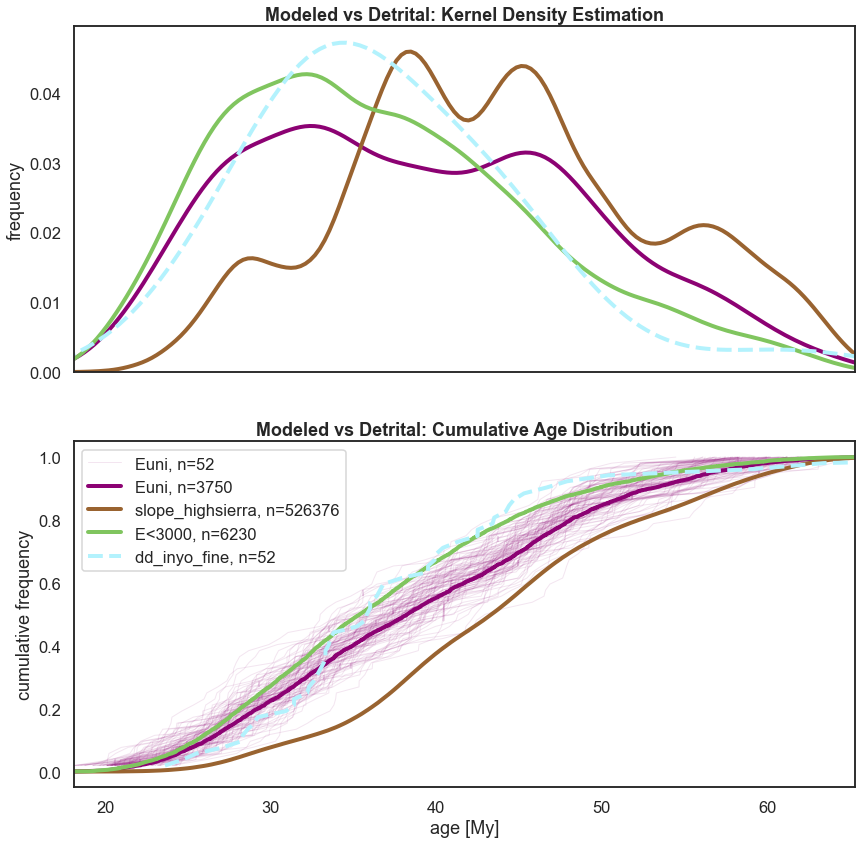

In [9]:
# ASSIGN PREFERRED VALUE FOR MULTIPLIER HERE #####################################################################
# This affects the total number of grains in each predicted detrital population,
# try starting with 1. If plots are too coarse, increase the number and re-run the code cell
multiplier = 10

# make dictionary of populations, one for each scenario
pops, scen_labels = make_pops_dict(opf+'/xyz_age_eros.xlsx', f_map_filename, multiplier)

# DEFINE REFERENCE SCENARIO HERE ##################################################################################
# By default the reference scenario is 'Euni' (spatially uniform erosion), but it can be assigned to be another one.
ref_scen = 'Euni' 
pops.move_to_end(ref_scen, last=False) # move ref_scen to first position in the dictionary

# also load the detrital data and make detrital populations
pops, dd, detr_labels = get_detr_pops(detrital_ages_filenames, pops, ipf)
# make dictionary of detrital distributions, one for each item of pops
dists = OrderedDict([(label, make_cdf(pop)) for label, pop in pops.items()])
    
# SPECIFY N. OF DETRITAL GRAIN AGES HERE ##########################################################################
# this is the number of grain-ages from which you obtain the observed detrital distribution,
# 52 grains are from Stock et al.'s' (2006) Inyo Creek case study
num_grains = 52

# check if something detrital is there at all, but it's not mandatory in case of explorative runs
if len(detrital_ages_filenames)<1:
    warnings.warn('\nYou have not specified any path to the detrital data.')

# Plot distributions
plot_distributions(pops, dists, ref_scen, detr_labels, opf+'/detrital_distributions.pdf', num_grains)

## Confidence in discerning between erosion scenarios and reference scenario as a function of sample size.

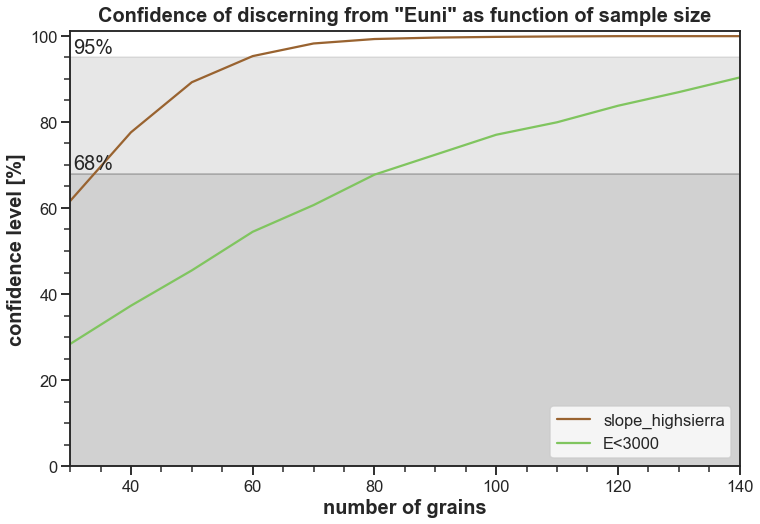

In [10]:
# DEFINE RANGE OF K VALUES AND N. OF ITERATIONS HERE ################################################################ 
all_k = np.arange(30,150,10) # possible n. of observed grain-ages (k) to consider, by default ranging between 30-140
k_iter = 1000 # iterations per k value, 1000 are generally enough to obtain meaningful plots

# make dictionary of all probabilities
probs = get_probabilities(pops, dists, all_k, k_iter, scen_labels, ref_scen)

# Plot the probabilities as function of scenario and sample size
plot_confidence(probs, all_k, ref_scen, opf+'/scenarios_confidence_sample_size.pdf', len(dists))

## How do the different scenarios compare to each other and to the detrital data?

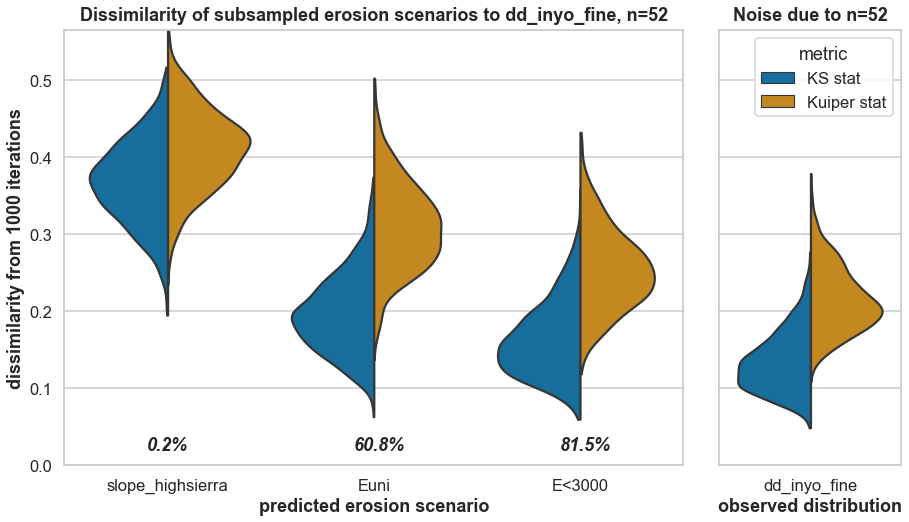

In [11]:
iterations = 1000 # number of iterations

# make detrital populations that account for analytical uncertainty and see how they compare to scenarios
pops_1sigma = make_pops_1sigma(dd, iterations)
scen2detr = get_scen2detr_diss(dd, pops, pops_1sigma, dists, scen_labels, iterations)

# calculate percentages of overlap between predictions and observations
# also make 68%-95% confidence intervals of KS statistic due to sample size
q68q95, overlaps = get_quantiles_and_overlaps(dd, scen2detr, pops, dists, scen_labels, iterations)

# check if detrital data are there
if len(detrital_ages_filenames)<1:
    warnings.warn('\nThere are no detrital distributions, the fit to detrital data cannot be calculated.\n')
else: # if yes, plot all violins to visually compare  
    for key,item in dd.items(): 
        plot_violins(scen2detr[key], key, 'divergence', opf+'/fit_to_'+key+'_data_violinplot.pdf',iterations,
                     len(item), overlaps)

## Multidimensional Scaling

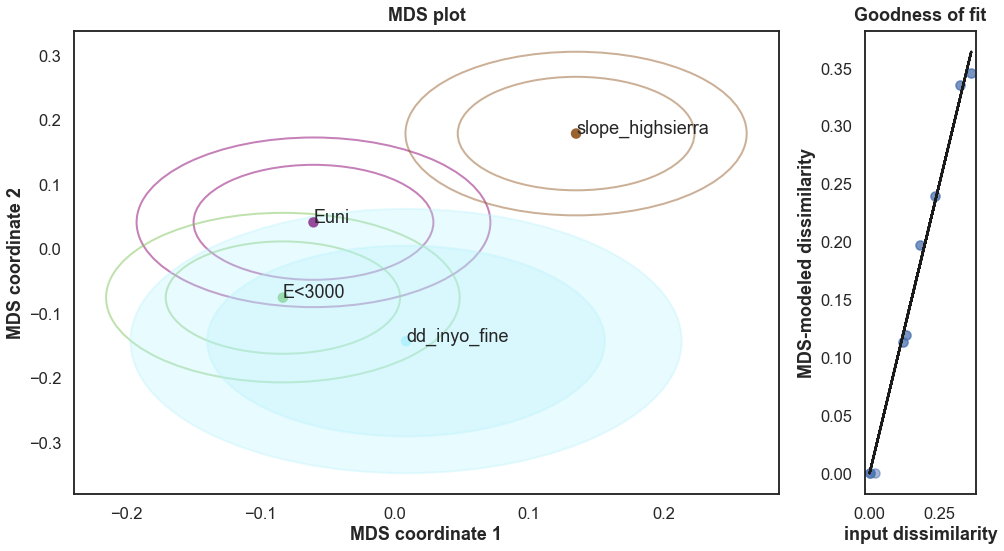

In [12]:
# make dissimilarity matrix and run metric Multi-Dimensional Scaling
diss = get_diss_matrix(pops)
x = MDS(n_components=2, metric=True, dissimilarity='precomputed',eps=1e-3).fit(diss)

# check if some detrital stuff is there. If not, warn the user
if len(detrital_ages_filenames)<1:
    warnings.warn('\nBear in mind, there are no detrital distributions here.\nPlease check the input parameters.')

# visualize dissimilarity among distributions, and related confidence intervals in a 2D map
plot_MDS_results(x, scm6.hawaii, pops, q68q95, scen_labels, opf+'/MDS_plot.pdf')

In [35]:
ws_data.slope_highsierra.max()

1723.4308939334667